ML For Credit Card Fraud Detection

1. Data Preparation
Start by preparing your data, including balancing the dataset if necessary.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Load your data
df = pd.read_csv(r"C:\Users\rohit\OneDrive\Desktop\Study IITJ\Projects\creditcard.csv")

# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for balancing the training dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


Shape and Describe

In [2]:
print(df.shape) # type: ignore
print(df.describe()) # type: ignore

(284807, 31)
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271

2. Feature Selection
Use SelectFromModel with a Logistic Regression model for efficient feature selection.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Use a Logistic Regression model for feature selection with increased max_iter
model = LogisticRegression(max_iter=5000, random_state=42)

# Fit the model to the balanced dataset
model.fit(X_train_balanced_scaled, y_train_balanced)

# Use SelectFromModel to select features based on the model coefficients
selector = SelectFromModel(estimator=model, prefit=True)

# Transform the datasets to select important features
X_train_selected = selector.transform(X_train_balanced_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Get the selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features)


Selected features: Index(['V1', 'V3', 'V4', 'V5', 'V7', 'V8', 'V10', 'V12', 'V14', 'V16', 'V17'], dtype='object')


Correlational Matrix

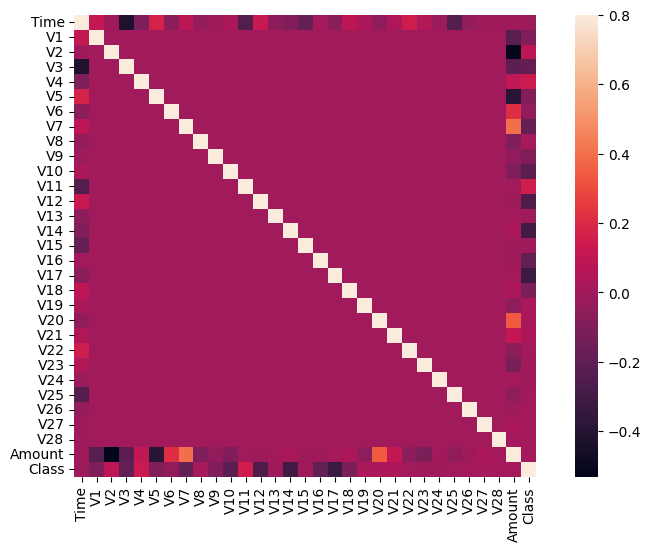

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# Correlation matrix
corrmat = df.corr()
fig = plt.figure(figsize = (10, 6))
sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()


3. Hyperparameter Tuning with Randomized Search
Use RandomizedSearchCV for hyperparameter tuning with the selected features.

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

# Define the SVM model
svm_model = SVC()

# Set up a reduced parameter grid for Randomized Search
param_grid = {
    'C': [0.1, 1, 10],  # Reduced range
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

# Set up Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(estimator=svm_model, param_distributions=param_grid, 
                                   n_iter=10, cv=3, scoring='f1', n_jobs=-1, random_state=42)

# Fit Randomized Search with the selected features
random_search.fit(X_train_selected, y_train_balanced)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best F1 Score: {random_search.best_score_}")


Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best F1 Score: 0.9868931058533857


In [6]:
import numpy as np
np.any(np.isnan(X_train_selected))  # Should return False
np.any(np.isinf(X_train_selected))  # Should return False


False

4. Gradient Boosting with XGBoost
XGBoost is a powerful boosting algorithm that often achieves high accuracy for classification tasks.

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from imblearn.over_sampling import SMOTE

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'scale_pos_weight': [1, 10, 20]  # Adjusting for class imbalance
}

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)

# Train the model with resampled data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_

# Predict probabilities for the test data
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# Adjust the threshold to improve precision and F1 score
threshold = 0.6  # You can experiment with this value
y_pred_xgb_adjusted = (y_pred_proba_xgb >= threshold).astype(int)

# Calculate evaluation metrics
xgb_accuracy_adj = accuracy_score(y_test, y_pred_xgb_adjusted)
xgb_precision_adj = precision_score(y_test, y_pred_xgb_adjusted)
xgb_recall_adj = recall_score(y_test, y_pred_xgb_adjusted)
xgb_f1_adj = f1_score(y_test, y_pred_xgb_adjusted)
xgb_mcc_adj = matthews_corrcoef(y_test, y_pred_xgb_adjusted)
xgb_auc_roc = roc_auc_score(y_test, y_pred_proba_xgb)

# Display the evaluation metrics
print(f"XGBoost (Adjusted Threshold) Accuracy: {xgb_accuracy_adj:.4f}")
print(f"XGBoost (Adjusted Threshold) Precision: {xgb_precision_adj:.4f}")
print(f"XGBoost (Adjusted Threshold) Recall: {xgb_recall_adj:.4f}")
print(f"XGBoost (Adjusted Threshold) F1-Score: {xgb_f1_adj:.4f}")
print(f"XGBoost (Adjusted Threshold) MCC: {xgb_mcc_adj:.4f}")
print(f"XGBoost (Adjusted Threshold) AUC-ROC: {xgb_auc_roc:.4f}")


Fitting 3 folds for each of 54 candidates, totalling 162 fits


c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:32:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (Adjusted Threshold) Accuracy: 0.9995
XGBoost (Adjusted Threshold) Precision: 0.8723
XGBoost (Adjusted Threshold) Recall: 0.8367
XGBoost (Adjusted Threshold) F1-Score: 0.8542
XGBoost (Adjusted Threshold) MCC: 0.8541
XGBoost (Adjusted Threshold) AUC-ROC: 0.9857


Logistic Regression Feature Selection (No Changes)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression model for feature selection
logreg_model = LogisticRegression(max_iter=5000, random_state=42)
logreg_model.fit(X_train_balanced_scaled, y_train_balanced)

# Feature selection based on coefficients
selector = SelectFromModel(estimator=logreg_model, prefit=True)
X_train_selected = selector.transform(X_train_balanced_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features)


Selected features: Index(['V1', 'V3', 'V4', 'V5', 'V7', 'V8', 'V10', 'V12', 'V14', 'V16', 'V17'], dtype='object')


RandomizedSearchCV for Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf,
                                      n_iter=10, cv=3, scoring='f1', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train_selected, y_train_balanced)

# Best parameters for Random Forest
best_rf_model = random_search_rf.best_estimator_
print(f"Best Random Forest Parameters: {random_search_rf.best_params_}")
print(f"Best F1 Score (RF): {random_search_rf.best_score_}")


Best Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best F1 Score (RF): 0.9996923167680253


Hyperparameter Tuning for LightGBM
python

In [10]:
import lightgbm as lgb # type: ignore
from sklearn.model_selection import GridSearchCV

# Initialize LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Parameter grid for LightGBM
param_grid_lgb = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Perform GridSearchCV
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, 
                               cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search_lgb.fit(X_train_selected, y_train_balanced)

# Best LightGBM model
best_lgb_model = grid_search_lgb.best_estimator_
print(f"Best LightGBM Parameters: {grid_search_lgb.best_params_}")
print(f"Best F1 Score (LGBM): {grid_search_lgb.best_score_}")


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

Overall

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve

# Load your data
df = pd.read_csv(r"C:\Users\rohit\OneDrive\Desktop\Study IITJ\Projects\creditcard.csv")

# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Apply SMOTE for balancing the training dataset (assuming SMOTE was applied previously)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Split the balanced dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Base models
logreg_model = LogisticRegression(max_iter=500, solver='saga', random_state=42)
svm_model = SVC(probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

# Calibrated classifiers for better probability estimates
calibrated_logreg = CalibratedClassifierCV(logreg_model, method='sigmoid')
calibrated_svm = CalibratedClassifierCV(svm_model, method='sigmoid')

# Meta-learner: Logistic Regression (faster than Gradient Boosting)
meta_learner = LogisticRegression(random_state=42)

# Stacking classifier with reduced cross-validation and meta-learner
stacked_clf = StackingClassifier(
    estimators=[('logreg', calibrated_logreg), ('svm', calibrated_svm), ('rf', rf_model)],
    final_estimator=meta_learner,
    cv=3,  # Reduced from 5 to 3 for faster computation
    n_jobs=-1
)

# Fit the stacking ensemble (use a subset for testing faster)
X_train_subset, _, y_train_subset, _ = train_test_split(X_train_scaled, y_train, test_size=0.9, random_state=42)
stacked_clf.fit(X_train_subset, y_train_subset)

# Predictions and threshold tuning
y_pred_proba = stacked_clf.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Apply the optimal threshold to predictions
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

# Print evaluation metrics
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Ensemble Accuracy: {accuracy:.4f}")
print(f"Ensemble Precision: {precision:.4f}")
print(f"Ensemble Recall: {recall:.4f}")
print(f"Ensemble F1-Score: {f1:.4f}")
print(f"Ensemble MCC: {mcc:.4f}")
print(f"Ensemble AUC-ROC: {auc_roc:.4f}")


Optimal Threshold: 0.37059067731052764
Ensemble Accuracy: 0.9987
Ensemble Precision: 0.9984
Ensemble Recall: 0.9990
Ensemble F1-Score: 0.9987
Ensemble MCC: 0.9974
Ensemble AUC-ROC: 0.9999
